## Set up

In [1]:
%matplotlib notebook

In [2]:
from qa import metrics, plots
from orca.metadata import pathsmanagers
from datetime import datetime, date
import os.path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import casatools
from collections import Counter
from functools import reduce
from astropy.io import fits
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [3]:
tb = casatools.table()

## Find data and calibration files

In [4]:
%cd /lustre/mmanders/exoplanet

/lustre/mmanders/exoplanet


In [5]:
%ls

BCAL/  dynspec/  processing/  RFIsprint/


In [6]:
user = 'mmanders'
spws = list(range(2, 8))
lst0_quiet = 7
lst1_quiet = 12

In [7]:
def getfiles(pathmanager, yymmdd, lst0=lst0_quiet, lst1=lst1_quiet):
    print(f"{len(yymmdd)} days: \n {yymmdd}")
    msfiles_list = []
    bpfiles_list = []
    fitsfiles_list = []
    for yy, mm, dd in yymmdd:
        start = datetime(2000 + yy, mm, dd, lst0_quiet, 0, 0)
        end = datetime(2000 + yy, mm, dd, lst1_quiet, 0, 0)
        print(f'start: {start}, end: {end}')
        pm = pathmanager.time_filter(start_time=start, end_time=end)
        bpfiles = []
        msfiles = []
        fitsfiles = []
        for s in spws:
            bpf = pm.get_gaintable_path(date(2000 + yy, mm, dd), f'{s:02d}', 'bcal')
            if os.path.exists(bpf):
                bpfiles.append(bpf)
        for t in pm.utc_times_mapping.keys():
            msf = pm.get_ms_path(t, f'{s:02d}')
            if os.path.exists(msf):
                msfiles.append(msf)
                fitsfiles.append(pm.get_data_product_path(t, 'msfiles',
                                                          '/' + str(t).replace(' ', 'T') + '-dirty.fits',
                                                          file_prefix=None))
        if len(bpfiles):
            bpfiles_list.append(bpfiles)
        if len(msfiles):
            msfiles_list.append(msfiles)
        if len(fitsfiles):
            fitsfiles_list.append(fitsfiles)
            
    print(f"{reduce(lambda count, l: count + len(l), msfiles_list, 0)} msfiles in {len(msfiles_list)} days")
    print("First and last MS data files:")
    print([msf.split('/')[-1] for msf in [msfiles_list[0][0], msfiles_list[-1][-1]]])

    print(f"{reduce(lambda count, l: count + len(l), bpfiles_list, 0)} bpfiles in {len(bpfiles_list)} days")
    print(['/'.join(bpf.split('/')[-2:]) for bpfiles in bpfiles_list for bpf in bpfiles])
    return bpfiles_list, msfiles_list, fitsfiles_list

def plotbp(bpfiles):
    bps = []
    snrs = []
    snrm = []
    for bpfile in bpfiles:
        tb.open(bpfile)
        bps.append(tb.getcol('CPARAM'))
        snr = tb.getcol('SNR')
        tb.close()
        snrs.append(snr)
        snrm.append(snr.mean(axis=2))
    bpa = np.concatenate(bps, axis=1)
    bpaa = np.abs(bpa)
    snra = np.concatenate(snrs, axis=1)
    snrm = np.array(snrm)
    nspw, npol, nch = snrm.shape
    npol, nch, nant = snr.shape
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, squeeze=True)
    ax1.plot(snrm[:, 0])
    ax1.set_ylabel('Pol 0 (mean per spw)')
    ax2.plot(snrm[:, 1])
    ax2.set_xlabel('SPW number')
    ax2.set_ylabel('Pol 1 (mean per spw)')
    ax1.set_title("Bandpass solution SNR per spw")
    return snrm, bpaa

def badbpsnr(snrm, thresh=0.7):
    nspw, npol, nant = snrm.shape
    wspw, wpol, want = np.where(snrm < thresh*np.median(snrm))
    if len(want):
        cc = Counter(want)
        print(f'Ant {list(cc.keys())} has {list(cc.values())} poor solutions')
    if len(wpol):
        cc = Counter(wpol)
        print(f'Pol {list(cc.keys())} has {list(cc.values())} poor solutions')
    if len(wspw):
        cc = Counter(wspw)
        print(f'SPW {list(cc.keys())} has {list(cc.values())} poor solutions')
        
    bad = np.zeros(shape=(npol, nspw, nant), dtype=bool)
    bad[wpol, wspw, want] = True

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,5), sharex='col')
    ax1.imshow(bad[0])
    ax1.set_ylabel("Pol 0 SPW")
    ax2.imshow(bad[1])
    ax2.set_ylabel("Pol 1 SPW")
    ax2.set_xlabel("Antenna")
    
def badbpa(bpaa, thresh=0.1):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, squeeze=True)
    ax1.plot(bpaa[0, :, :], '.')
    ax2.set_xlabel('Channel')
    ax1.set_ylabel('Pol 0 amplitude')
    ax2.plot(bpaa[1, :, :], '.')
    ax2.set_ylabel('Pol 1 amplitude')
    ax1.set_title("Bandpass amplitude")
    
    wpol, wch, want = np.where(bpaa < thresh*np.median(bpaa))
    if len(want):
        cc = Counter(want)
        print(f'Ant {list(cc.keys())} has {list(cc.values())} poor solutions')
    if len(wpol):
        cc = Counter(wpol)
        print(f'Pol {list(cc.keys())} has {list(cc.values())} poor solutions')
    if len(wch):
        cc = Counter(wch)
        print(f'Channel {list(cc.keys())} has {list(cc.values())} poor solutions')

    bad = np.zeros(shape=(npol, nant, nch*nspw), dtype=bool)
    bad[wpol, want, wch] = True

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5), sharey='row')
    ax1.imshow(bad[0])
    ax1.set_ylabel("Antenna")
    ax1.set_xlabel("Channel (Pol 0)")
    ax2.imshow(bad[1])
    ax2.set_xlabel("Channel (Pol 1)")
    
    
def imagestats(fitsfiles_list, maxnum=100):
    stds = []
    maxs = []
    names = []
    totalnum = sum([len(ff) for ff in fitsfiles_list])
    skip = int(totalnum/min(maxnum, totalnum))
    print(f'Reading {min(maxnum, totalnum)} of total of {totalnum}')
    for fitsfiles in fitsfiles_list:
        print(f'Directory has {len(fitsfiles)} fits files like {fitsfiles[0]}')
        for fitsfile in fitsfiles[::skip]:
            if os.path.exists(fitsfile):
                fd = fits.getdata(fitsfile)
                stds.append(fd.std())
                maxs.append(fd.max())
                names.append(fitsfile)
            else:
                print(f'fits file {fitsfile} not found. Skipping.')
    return stds, maxs, names

def imageplots(stds, maxs, names):
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.plot(stds)
    ax1.set_ylabel('std')
    ax2.plot(maxs)
    ax2.set_xlabel('image')
    ax2.set_ylabel('max')
    
    TOOLS = ["box_select", "hover", "reset", "pan"]
    TOOLTIPS = [('std', '@std'), ('max', '@max'), ('image', '@name')]
    source = dict(std=stds, max=maxs, name=[name.split('/')[-1] for name in names])
    p1 = figure(plot_width=800, plot_height=400, tools=TOOLS, tooltips=TOOLTIPS)
    p1.circle(source=source, x='std', y='max')
    show(p1, notebook_handle=True)

## First 2019 campaign

In [8]:
pm_20191121 = pathsmanagers.OfflinePathsManager(
                  utc_times_txt_path='/lustre/data/2019-11-21_rainydata/utc_times.txt',
                  dadafile_dir='/lustre/data/2019-11-21_rainydata',
                  working_dir=f'/lustre/{user}/exoplanet/processing',
                  gaintable_dir=f'/lustre/{user}/exoplanet/processing/BCAL')
yymmdd_20191121 = [(19, 11, 21), (19, 11, 22)]

In [9]:
bpfiles_list, msfiles_list, fitsfiles_list = getfiles(pm_20191121, yymmdd_20191121)

2 days: 
 [(19, 11, 21), (19, 11, 22)]
start: 2019-11-21 07:00:00, end: 2019-11-21 12:00:00
start: 2019-11-22 07:00:00, end: 2019-11-22 12:00:00
1385 msfiles in 1 days
First and last MS data files:
['07_2019-11-22T07:00:03.ms', '07_2019-11-22T11:59:55.ms']
12 bpfiles in 2 days
['2019-11-21/02.bcal', '2019-11-21/03.bcal', '2019-11-21/04.bcal', '2019-11-21/05.bcal', '2019-11-21/06.bcal', '2019-11-21/07.bcal', '2019-11-22/02.bcal', '2019-11-22/03.bcal', '2019-11-22/04.bcal', '2019-11-22/05.bcal', '2019-11-22/06.bcal', '2019-11-22/07.bcal']


In [10]:
for bpfiles in bpfiles_list:
    snrm, bpaa = plotbp(bpfiles)
    nspw, npol, nch = snrm.shape
    npol, nchnspw, nant = bpaa.shape
    badbpsnr(snrm)
    badbpa(bpaa)

<IPython.core.display.Javascript object>

Ant [5, 53, 72, 108, 0, 2, 3, 4, 6, 12, 13, 14, 15, 24, 1, 96] has [2, 2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2] poor solutions
Pol [0, 1] has [8, 18] poor solutions
SPW [0, 1, 5] has [18, 6, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 102, 103, 104, 105, 118, 127, 128, 145, 148, 153, 156, 157, 158, 159, 161, 164, 167, 168, 184, 193, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 146, 147, 149, 150, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 151, 152, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [2, 3, 4, 32, 33, 34, 35, 36, 37, 38, 39, 68, 69, 70, 71, 86, 25, 26, 27, 28, 29, 101, 0, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [24, 24] poor solutions
SPW [1, 2, 4, 5] has [32, 10, 2, 4] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 76, 77, 78, 79, 82, 87, 104, 105, 127, 128, 145, 148, 153, 156, 157, 158, 159, 161, 164, 167, 168, 184, 197, 201, 202, 203, 209, 210, 216, 219, 220, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 103, 146, 147, 149, 150, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 151, 152, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 

<IPython.core.display.Javascript object>

In [11]:
# flagging

In [12]:
stds, maxs, names = imagestats(fitsfiles_list)

Reading 100 of total of 1385
Directory has 1385 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2019-11-22/hh=07/2019-11-22T07:00:03/2019-11-22T07:00:03-dirty.fits
fits file /lustre/mmanders/exoplanet/processing/msfiles/2019-11-22/hh=09/2019-11-22T09:51:52/2019-11-22T09:51:52-dirty.fits not found. Skipping.
fits file /lustre/mmanders/exoplanet/processing/msfiles/2019-11-22/hh=09/2019-11-22T09:54:41/2019-11-22T09:54:41-dirty.fits not found. Skipping.
fits file /lustre/mmanders/exoplanet/processing/msfiles/2019-11-22/hh=09/2019-11-22T09:57:30/2019-11-22T09:57:30-dirty.fits not found. Skipping.
fits file /lustre/mmanders/exoplanet/processing/msfiles/2019-11-22/hh=10/2019-11-22T10:00:19/2019-11-22T10:00:19-dirty.fits not found. Skipping.
fits file /lustre/mmanders/exoplanet/processing/msfiles/2019-11-22/hh=10/2019-11-22T10:03:08/2019-11-22T10:03:08-dirty.fits not found. Skipping.
fits file /lustre/mmanders/exoplanet/processing/msfiles/2019-11-22/hh=10/2019-11-22T10:05:57/2019

In [13]:
imageplots(stds, maxs, names)

<IPython.core.display.Javascript object>

## Second 2019 campaign

In [14]:
pm_20191204 = pathsmanagers.OfflinePathsManager(
                  utc_times_txt_path='/lustre/data/exoplanet/utc_times.txt.20210114',
                  dadafile_dir='/lustre/data/exoplanet',
                  working_dir=f'/lustre/{user}/exoplanet/processing',
                  gaintable_dir=f'/lustre/{user}/exoplanet/processing/BCAL')
yymmdd_20191204 = list(zip([19]*9, [12]*9, range(5, 13))) 

In [15]:
bpfiles_list, msfiles_list, fitsfiles_list = getfiles(pm_20191204, yymmdd_20191204)

8 days: 
 [(19, 12, 5), (19, 12, 6), (19, 12, 7), (19, 12, 8), (19, 12, 9), (19, 12, 10), (19, 12, 11), (19, 12, 12)]
start: 2019-12-05 07:00:00, end: 2019-12-05 12:00:00
start: 2019-12-06 07:00:00, end: 2019-12-06 12:00:00
start: 2019-12-07 07:00:00, end: 2019-12-07 12:00:00
start: 2019-12-08 07:00:00, end: 2019-12-08 12:00:00
start: 2019-12-09 07:00:00, end: 2019-12-09 12:00:00
start: 2019-12-10 07:00:00, end: 2019-12-10 12:00:00
start: 2019-12-11 07:00:00, end: 2019-12-11 12:00:00
start: 2019-12-12 07:00:00, end: 2019-12-12 12:00:00
2812 msfiles in 8 days
First and last MS data files:
['07_2019-12-05T10:57:34.ms', '07_2019-12-12T11:59:47.ms']
48 bpfiles in 8 days
['2019-12-05/02.bcal', '2019-12-05/03.bcal', '2019-12-05/04.bcal', '2019-12-05/05.bcal', '2019-12-05/06.bcal', '2019-12-05/07.bcal', '2019-12-06/02.bcal', '2019-12-06/03.bcal', '2019-12-06/04.bcal', '2019-12-06/05.bcal', '2019-12-06/06.bcal', '2019-12-06/07.bcal', '2019-12-07/02.bcal', '2019-12-07/03.bcal', '2019-12-07/04.b

In [16]:
for bpfiles in bpfiles_list:
    snrm, bpaa = plotbp(bpfiles)
    nspw, npol, nch = snrm.shape
    npol, nchnspw, nant = bpaa.shape
    badbpsnr(snrm)
    badbpa(bpaa)

<IPython.core.display.Javascript object>

Ant [10, 11, 24, 12, 25, 64, 65, 66, 67, 99, 105, 96] has [2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [10, 12] poor solutions
SPW [0, 1, 3, 5] has [8, 10, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 117, 118, 127, 128, 145, 148, 153, 156, 157, 158, 159, 161, 164, 167, 168, 184, 193, 197, 201, 202, 209, 210, 219, 220, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 166, 115, 116, 191, 114, 113] has [218, 1308, 1308, 654, 436, 1308, 1308, 872, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 439, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 872, 872, 218, 436, 218] poor solutions
Pol [0, 1] has [38807, 38804] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 32, 39, 40, 41, 42, 43, 44, 45, 74, 75, 76, 77, 91, 108, 7, 90] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2] poor solutions
Pol [0, 1] has [18, 19] poor solutions
SPW [0, 1, 2] has [6, 29, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 32, 39, 40, 41, 42, 43, 44, 45, 108, 92, 90, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2] poor solutions
Pol [0, 1] has [15, 16] poor solutions
SPW [0, 1, 2, 5] has [8, 19, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

/opt/astro/devel/claw/.conda/envs/py36_orca/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 46, 6, 32, 107, 108, 3, 62, 96] has [4, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [11, 12] poor solutions
SPW [0, 1, 5] has [7, 8, 8] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [50, 32, 34, 35, 36, 37, 38, 39, 40, 87, 103, 104, 105, 69, 70, 71, 72, 26, 27, 28, 29, 30, 90, 96] has [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [1, 0] has [24, 19] poor solutions
SPW [0, 1, 2, 5] has [1, 28, 12, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 76, 77, 78, 79, 82, 87, 104, 105, 115, 116, 117, 118, 127, 145, 148, 153, 156, 157, 158, 159, 161, 164, 167, 168, 184, 193, 195, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 177, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [108, 0, 1, 2, 31, 32, 33, 34, 35, 36, 37, 23, 24, 25, 26, 27, 38, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2] poor solutions
Pol [0, 1] has [18, 17] poor solutions
SPW [0, 1, 2, 4, 5] has [2, 20, 10, 1, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 117, 118, 127, 128, 145, 148, 153, 156, 157, 158, 159, 161, 164, 167, 168, 184, 193, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [95, 3, 96] has [2, 2, 2] poor solutions
Pol [0, 1] has [3, 3] poor solutions
SPW [1, 5] has [2, 4] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 128, 145, 148, 153, 156, 157, 158, 159, 161, 164, 167, 168, 184, 193, 195, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [4, 10, 16, 22, 34, 40, 46, 63, 98, 99, 100, 101, 28, 52, 58, 21, 23, 24, 25, 26, 27, 32, 56, 57, 59, 74, 89, 13, 14, 15, 17, 81, 5, 11] has [4, 4, 6, 6, 3, 3, 2, 2, 2, 2, 2, 2, 3, 1, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2] poor solutions
Pol [0, 1] has [41, 46] poor solutions
SPW [0, 1, 2, 5] has [27, 31, 13, 16] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 27, 43, 44, 56, 57, 58, 59, 62, 76, 77, 78, 79, 82, 87, 104, 105, 127, 128, 145, 148, 153, 156, 157, 158, 159, 161, 164, 167, 168, 184, 193, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 

<IPython.core.display.Javascript object>

## First 2020 campaign

In [17]:
pm_20200117 = pathsmanagers.OfflinePathsManager(utc_times_txt_path='/lustre/data/exoplanet_20200117/utc_times.txt',
                                                dadafile_dir='/lustre/data/exoplanet_20200117',
                                                working_dir=f'/lustre/{user}/exoplanet/processing',
                                                gaintable_dir=f'/lustre/{user}/exoplanet/processing/BCAL')

# define spw and month,day ranges for exoplanet run
yymmdd_20200117 = list(zip([20]*(31-17+1), [1]*(31-17+1), range(17, 32))) + list(zip([20]*13, [2]*13, range(1, 14)))

In [18]:
bpfiles_list, msfiles_list, fitsfiles_list = getfiles(pm_20200117, yymmdd_20200117)

28 days: 
 [(20, 1, 17), (20, 1, 18), (20, 1, 19), (20, 1, 20), (20, 1, 21), (20, 1, 22), (20, 1, 23), (20, 1, 24), (20, 1, 25), (20, 1, 26), (20, 1, 27), (20, 1, 28), (20, 1, 29), (20, 1, 30), (20, 1, 31), (20, 2, 1), (20, 2, 2), (20, 2, 3), (20, 2, 4), (20, 2, 5), (20, 2, 6), (20, 2, 7), (20, 2, 8), (20, 2, 9), (20, 2, 10), (20, 2, 11), (20, 2, 12), (20, 2, 13)]
start: 2020-01-17 07:00:00, end: 2020-01-17 12:00:00
start: 2020-01-18 07:00:00, end: 2020-01-18 12:00:00
start: 2020-01-19 07:00:00, end: 2020-01-19 12:00:00
start: 2020-01-20 07:00:00, end: 2020-01-20 12:00:00
start: 2020-01-21 07:00:00, end: 2020-01-21 12:00:00
start: 2020-01-22 07:00:00, end: 2020-01-22 12:00:00
start: 2020-01-23 07:00:00, end: 2020-01-23 12:00:00
start: 2020-01-24 07:00:00, end: 2020-01-24 12:00:00
start: 2020-01-25 07:00:00, end: 2020-01-25 12:00:00
start: 2020-01-26 07:00:00, end: 2020-01-26 12:00:00
start: 2020-01-27 07:00:00, end: 2020-01-27 12:00:00
start: 2020-01-28 07:00:00, end: 2020-01-28 12:00:

In [19]:
for bpfiles in bpfiles_list:
    snrm, bpaa = plotbp(bpfiles)
    nspw, npol, nch = snrm.shape
    npol, nchnspw, nant = bpaa.shape
    badbpsnr(snrm)
    badbpa(bpaa)

<IPython.core.display.Javascript object>

Ant [26, 27, 28, 29, 30, 31, 60, 61, 62, 63, 64, 78, 79, 94, 95, 96, 97, 18, 19, 20, 21, 22, 32, 86, 87] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [25, 25] poor solutions
SPW [0, 1] has [34, 16] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 184, 191, 195, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 211, 47, 177, 99, 101, 102, 103] has [1308, 1308, 654, 436, 1308, 1308, 654, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 1308, 654, 1308, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 654, 872, 218, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [39894, 39894] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [29, 30, 31, 32, 33, 34, 35, 64, 65, 66, 67, 22, 23, 24, 25, 90] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [16, 16] poor solutions
SPW [0, 1] has [22, 10] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 47, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 172, 184, 197, 201, 202, 203, 209, 210, 216, 219, 220, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 31, 99, 23, 24, 25, 26, 90, 62] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [10, 10] poor solutions
SPW [0, 1, 2, 4] has [8, 8, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [1, 2, 32, 33, 34, 35, 36, 37, 67, 68, 69, 100, 101, 102, 90, 105, 9] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1] poor solutions
Pol [0, 1] has [17, 16] poor solutions
SPW [0, 2, 3] has [28, 4, 1] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 112, 127, 145, 148, 156, 157, 158, 159, 161, 162, 164, 166, 167, 168, 184, 191, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 107, 177, 106, 110, 103, 102] has [1308, 1308, 654, 436, 1308, 1308, 654, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 218, 1308, 1308, 1308, 654, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 654, 654, 436, 218, 218] poor solutions
Pol [0, 1] has [40439, 40439] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [2, 32, 33, 34, 35, 36, 37, 38, 67, 68, 69, 70, 101, 102, 103, 90, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1] poor solutions
Pol [0, 1] has [17, 16] poor solutions
SPW [0, 2, 5] has [30, 2, 1] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 184, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [2, 33, 34, 35, 36, 37, 38, 68, 69, 70, 101, 102, 103, 32, 90, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1] poor solutions
Pol [0, 1] has [16, 15] poor solutions
SPW [0, 1, 2, 5] has [26, 2, 2, 1] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 169, 170, 184, 191, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 106, 107, 177, 47, 99, 101, 102, 110] has [1308, 1308, 654, 436, 1308, 1308, 654, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 218, 218, 1308, 436, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 872, 1090, 654, 654, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [40766, 40766] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [3, 33, 34, 35, 36, 37, 38, 39, 68, 69, 70, 102, 103, 26, 27, 28, 32, 25, 90, 9, 15, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [21, 22] poor solutions
SPW [0, 1, 2, 3, 5] has [26, 9, 2, 4, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 162, 164, 166, 167, 168, 169, 170, 184, 187, 191, 195, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 108, 109, 106, 107, 177, 47, 102, 103, 110] has [1308, 1308, 654, 436, 1308, 1308, 1090, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 436, 1308, 1308, 218, 218, 1308, 436, 654, 1308, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1090, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 1090, 654, 872, 218, 436, 218, 218, 218] poor solutions
Pol [0, 1] has [41529, 41529] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 9, 16, 17, 23, 24, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 63, 64, 65, 66, 67, 68, 69, 70, 71, 76, 79, 80, 81, 82, 102, 103, 104, 105, 106, 107, 108, 32, 62, 97, 20, 21, 22, 26, 27, 28, 29, 58, 59, 94, 95, 96, 84, 87, 88, 90, 86, 48] has [6, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 1, 1] poor solutions
Pol [0, 1] has [72, 79] poor solutions
SPW [0, 1, 2, 3, 4, 5] has [95, 35, 10, 4, 2, 5] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 66, 76, 77, 78, 79, 82, 86, 87, 95, 104, 105, 108, 118, 122, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 175, 177, 182, 183, 184, 191, 197, 201, 202, 203, 209, 210, 216, 217, 219, 220, 221, 222, 224, 225, 236, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 144, 193, 109, 125, 0, 107, 128, 195, 61, 106, 102, 223, 226, 227] has [1308, 1308, 654, 436, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 218, 1308, 436, 1308, 1308, 1308, 218, 872, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 872, 218, 218, 1308, 1308, 1308, 1308, 436, 1308, 1308, 1308, 1308, 218, 1308, 1308, 654, 1308, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1, 655, 1090, 654, 654, 872, 654, 654, 654, 436, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [44692, 44690] poor solutions
Channel [0, 1, 2, 3, 4, 5,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [3, 34, 35, 36, 37, 38, 39, 27, 28, 29, 90, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [12, 12] poor solutions
SPW [0, 1, 2, 5] has [14, 6, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 95, 104, 105, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 184, 191, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [2, 3, 4, 5, 34, 35, 36, 37, 38, 39, 40, 44, 69, 70, 71, 87, 102, 103, 104, 105, 72, 27, 28, 29, 32, 95, 90, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [27, 28] poor solutions
SPW [0, 1, 2, 5] has [41, 10, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 95, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 177, 184, 188, 191, 195, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 28, 128, 193, 211, 223, 103, 108, 109, 226, 227, 33, 71, 86, 89, 137, 140, 175, 178, 196, 198, 199, 235, 236] has [1308, 1308, 654, 436, 1308, 1308, 436, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 872, 1308, 218, 1308, 1308, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 872, 436, 872, 872, 436, 654, 218, 436, 436, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [43600, 43600] poor solutions

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [4, 5, 35, 36, 37, 38, 39, 40, 41, 103, 27, 28, 29, 30, 32, 96, 90, 62] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 4, 2, 2] poor solutions
Pol [0, 1] has [18, 19] poor solutions
SPW [0, 1, 2, 4, 5] has [19, 12, 2, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 184, 191, 195, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [3, 35, 36, 43, 44, 45, 55, 56, 57, 58, 59, 69, 90, 91, 102, 15, 32, 48, 60, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [22, 22] poor solutions
SPW [0, 1, 2, 5] has [30, 10, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 95, 104, 105, 106, 108, 109, 110, 111, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 175, 177, 184, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 107, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [5, 6, 7, 39, 40, 57, 58, 59, 72, 73, 105, 106, 41, 107, 32, 62, 63, 64, 29, 19, 20, 90, 9, 65, 69, 87, 88, 99, 44, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [29, 32] poor solutions
SPW [0, 1, 2, 3, 4, 5] has [26, 9, 6, 12, 4, 4] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 55, 56, 57, 59, 62, 76, 77, 78, 79, 82, 86, 87, 95, 104, 105, 118, 127, 145, 148, 153, 156, 157, 158, 159, 161, 164, 167, 168, 175, 177, 184, 191, 197, 201, 203, 209, 210, 216, 217, 219, 220, 221, 222, 224, 225, 236, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 18, 25, 26, 36, 58, 63, 81, 84, 89, 108, 110, 113, 115, 129, 155, 207, 211, 0, 28, 93, 109, 128, 193, 223, 102, 122, 125, 226, 227, 33, 61, 85, 90, 111, 112, 114, 119, 178, 202, 235, 73, 163] has [1308, 1308, 654, 436, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 654, 1308, 654, 1308, 1308, 436, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1090, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 872, 1308, 1308, 1308, 654, 1308, 1090, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 218, 218, 218, 654, 872, 218, 218, 436, 1090, 218, 218, 436, 218, 218, 436, 872, 872,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [3, 4, 5, 6, 7, 8, 36, 37, 38, 39, 40, 41, 42, 43, 44, 53, 54, 55, 56, 70, 71, 72, 73, 74, 75, 103, 104, 105, 106, 107, 108, 9, 0, 28, 29, 30, 31, 32, 60, 61, 62, 63, 64, 65, 66, 67, 94, 95, 96, 18, 19, 20, 21, 85, 86, 87, 90, 22, 23, 88, 10, 11, 12, 45, 46, 47, 77, 78] has [2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 6, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [77, 79] poor solutions
SPW [0, 1, 2, 3, 4, 5] has [63, 34, 19, 10, 10, 20] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 95, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 184, 191, 195, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 107, 108, 109, 236, 0, 106, 128, 175, 193, 102, 61, 122] has [1308, 1308, 654, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 1308, 654, 872, 1308, 1308, 436, 1308, 1308, 1308, 436, 1308, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 1090, 1090, 218, 436, 654, 436, 218, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [42510, 42510] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [52, 53, 54, 55, 90, 82, 99, 96] has [2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [8, 8] poor solutions
SPW [0, 2, 3, 4, 5] has [8, 2, 2, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 170, 184, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 21, 106, 107, 177, 191, 99, 101, 102, 110] has [1308, 1308, 654, 436, 1308, 1308, 872, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 654, 872, 1090, 654, 872, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [41420, 41420] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [3, 4, 5, 6, 7, 8, 9, 36, 37, 38, 39, 40, 41, 42, 43, 44, 54, 55, 56, 70, 71, 72, 73, 74, 75, 103, 104, 105, 106, 107, 108, 0, 27, 28, 29, 30, 31, 32, 59, 60, 61, 62, 63, 64, 65, 66, 67, 94, 95, 96, 13, 18, 19, 20, 21, 22, 90, 17, 86, 48, 87, 23, 88, 45, 46, 47, 78] has [2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 8, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 1, 2, 2, 4, 4, 4, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [80, 83] poor solutions
SPW [0, 1, 2, 3, 4, 5] has [62, 39, 20, 16, 10, 16] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 95, 104, 105, 113, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 177, 184, 187, 191, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 60, 108, 109, 126, 211, 236, 239, 0, 107, 128, 106, 102, 110, 193, 61, 86, 122, 125] has [1308, 1308, 654, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 654, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 872, 1308, 654, 872, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1090, 1090, 218, 436, 436, 218, 436, 872, 436, 436, 218, 218, 218, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [43164, 43164] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [40, 41, 42, 43, 75, 108, 44, 0, 32, 90, 9, 69, 72, 82, 87, 77, 78, 99] has [2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [17, 18] poor solutions
SPW [0, 1, 2, 3, 4] has [13, 4, 2, 10, 6] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 106, 107, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 171, 177, 184, 191, 197, 201, 202, 203, 209, 210, 216, 219, 220, 221, 222, 224, 225, 227, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 110, 22, 38, 89, 102, 192] has [218, 1308, 1308, 654, 436, 1308, 1308, 872, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 218, 1090, 1308, 436, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 1308, 654, 1308, 1090, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 654, 218, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [42728, 42728] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [24, 25, 26, 27, 28, 29, 30, 60, 93, 94, 16, 17, 18, 19, 32, 90] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [16, 16] poor solutions
SPW [0, 1, 2] has [20, 10, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 162, 164, 166, 167, 168, 169, 170, 177, 179, 184, 187, 191, 195, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 108, 109, 45, 102, 103, 106, 107, 0, 128] has [1308, 1308, 654, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 218, 1308, 1308, 218, 218, 1090, 1308, 1308, 654, 1090, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 872, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 654, 218, 218, 218, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [42728, 42728] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 58, 59, 60, 61, 62, 63, 89, 90, 87, 77, 96] has [2, 1, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 4, 2, 2, 2] poor solutions
Pol [0, 1] has [70, 67] poor solutions
SPW [0, 1, 2, 3, 4, 5] has [121, 4, 2, 6, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 60, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 126, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 170, 171, 177, 179, 184, 187, 195, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 108, 107, 109, 191, 106, 102, 110] has [1308, 1308, 654, 436, 1308, 1308, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 218, 218, 1090, 1308, 1308, 872, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 872, 872, 436, 654, 218, 218] poor solutions
Pol [0, 1] has [44036, 44036] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [26, 27, 28, 29, 61, 94, 95, 18, 19, 32, 57, 90, 9, 69, 72, 73, 82, 99, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [19, 19] poor solutions
SPW [0, 1, 2, 3, 4, 5] has [14, 6, 4, 10, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 170, 177, 184, 191, 195, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 106, 107, 91, 169, 189, 212, 213, 102, 103, 110] has [1308, 1308, 654, 436, 1308, 1308, 436, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 218, 1090, 1308, 436, 872, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 654, 872, 218, 218, 218, 218, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [41093, 41093] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [32, 33, 34, 35, 44, 45, 46, 43, 47, 78, 90, 96] has [4, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2] poor solutions
Pol [0, 1] has [10, 13] poor solutions
SPW [0, 1, 2, 5] has [17, 2, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 184, 191, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 223, 224, 225, 226, 227, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 107, 103, 106, 110, 102] has [1308, 1308, 654, 436, 1308, 1308, 436, 1308, 1308, 872, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 1308, 654, 1308, 1308, 436, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 218, 1308, 1308, 218, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 436, 872, 436, 218] poor solutions
Pol [0, 1] has [40984, 40984] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [6, 72, 29, 30, 31, 32, 90, 96] has [2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [8, 8] poor solutions
SPW [0, 1, 2, 5] has [4, 8, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 184, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [11, 12, 13, 43, 44, 45, 46, 47, 48, 49, 50, 32, 90, 9, 82, 87, 99] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [17, 17] poor solutions
SPW [0, 1, 2, 3, 4] has [22, 2, 2, 6, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 21, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 106, 107, 108, 109, 127, 145, 148, 156, 157, 158, 159, 161, 164, 166, 167, 168, 177, 184, 191, 195, 197, 201, 202, 203, 209, 210, 211, 212, 216, 219, 220, 221, 222, 224, 225, 227, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 110, 103, 102] has [1308, 1308, 654, 654, 436, 1308, 1308, 436, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 1090, 1308, 872, 654, 1308, 1308, 218, 1308, 1308, 1308, 218, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 654, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 872, 436, 218] poor solutions
Pol [0, 1] has [42401, 42401] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [33, 34, 35, 36, 37, 38, 39, 101, 2, 25, 26, 27, 28, 29, 105, 96] has [2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [15, 16] poor solutions
SPW [0, 1, 2, 5] has [17, 10, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 128, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 179, 184, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 181, 182, 183, 185, 186, 187, 188, 189, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [4, 5, 34, 35, 36, 37, 38, 39, 40, 41, 69, 87, 88, 103, 104, 105, 106, 27, 28, 29, 30, 31, 62] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [23, 23] poor solutions
SPW [0, 1, 4] has [34, 10, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 179, 184, 191, 195, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 181, 182, 183, 185, 186, 187, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 41, 25, 42, 43, 44, 45, 46, 47, 32, 34, 96] has [4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2] poor solutions
Pol [0, 1] has [30, 37] poor solutions
SPW [0, 1, 5] has [59, 6, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 179, 184, 191, 195, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 181, 182, 183, 185, 186, 187, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 10, 11, 12, 13, 41, 42, 43, 44, 45, 46, 94, 0, 1, 2, 3, 101, 32, 96] has [1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2] poor solutions
Pol [0, 1] has [18, 16] poor solutions
SPW [0, 1, 5] has [21, 11, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 60, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 109, 126, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 179, 184, 187, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 223, 224, 225, 226, 227, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 180, 181, 182, 183, 185, 

<IPython.core.display.Javascript object>

## Flagging summary

### Flagging by channel (over all spw)

In [20]:
# Plot some fraction of all ms data files
fracs = [(msf, metrics.flagfrac_chans(msf)) for (msf, *_) in msfiles_list[::len(msfiles_list)//10]]

In [21]:
fig = plt.figure(figsize=(9, 5))
for msf, frac in fracs[::len(fracs)]:
    plt.plot(range(109), frac, '.', label=msf.split('/')[-1])
plt.xlabel("Channel number")
plt.ylabel("Flagging fraction")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Flagging fraction')

In [22]:
for msf, frac in fracs:
    nch = len(np.where(np.array(frac) == 1.0)[0])
    print(msf, nch)

/lustre/mmanders/exoplanet/processing/msfiles/2020-01-17/hh=08/2020-01-17T08:08:34/07_2020-01-17T08:08:34.ms 2
/lustre/mmanders/exoplanet/processing/msfiles/2020-01-19/hh=08/2020-01-19T08:00:42/07_2020-01-19T08:00:42.ms 4
/lustre/mmanders/exoplanet/processing/msfiles/2020-01-21/hh=07/2020-01-21T07:52:50/07_2020-01-21T07:52:50.ms 3
/lustre/mmanders/exoplanet/processing/msfiles/2020-01-23/hh=07/2020-01-23T07:44:58/07_2020-01-23T07:44:58.ms 5
/lustre/mmanders/exoplanet/processing/msfiles/2020-01-25/hh=07/2020-01-25T07:37:06/07_2020-01-25T07:37:06.ms 1
/lustre/mmanders/exoplanet/processing/msfiles/2020-01-27/hh=07/2020-01-27T07:29:14/07_2020-01-27T07:29:14.ms 4
/lustre/mmanders/exoplanet/processing/msfiles/2020-01-29/hh=07/2020-01-29T07:21:22/07_2020-01-29T07:21:22.ms 2
/lustre/mmanders/exoplanet/processing/msfiles/2020-01-31/hh=07/2020-01-31T07:13:30/07_2020-01-31T07:13:30.ms 3
/lustre/mmanders/exoplanet/processing/msfiles/2020-02-02/hh=07/2020-02-02T07:05:38/07_2020-02-02T07:05:38.ms 2
/

### Flagging over antenna

In [23]:
corrs = plots.corr_flagfrac(msfiles_list[0][0], showplot=False, saveplot=False)

fig = plt.figure(figsize=(8,8))
i = 1
for msfiles in msfiles_list[1:]:
    msfile = msfiles[0]
    corrs += plots.corr_flagfrac(msfile, showplot=False, saveplot=False)
    i += 1
corrs /= i
im = plt.matshow(corrs, norm=LogNorm(vmin=1.e-2, vmax=1))
plt.colorbar()

Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol


<IPython.core.display.Javascript object>

Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 2

<IPython.core.display.Javascript object>

### Image analysis

In [24]:
stds = []
maxs = []
names = []
for fitsfiles in fitsfiles_list:
    print(f'Directory has {len(fitsfiles)} fits files like {fitsfiles[0]}')
    for fitsfile in fitsfiles[::100]:
        fd = fits.getdata(fitsfile)
        stds.append(fd.std())
        maxs.append(fd.max())
        names.append(fitsfile)

Directory has 1069 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-01-17/hh=08/2020-01-17T08:08:34/2020-01-17T08:08:34-dirty.fits
Directory has 1087 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-01-18/hh=08/2020-01-18T08:04:38/2020-01-18T08:04:38-dirty.fits
Directory has 1105 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-01-19/hh=08/2020-01-19T08:00:42/2020-01-19T08:00:42-dirty.fits
Directory has 1123 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-01-20/hh=07/2020-01-20T07:56:46/2020-01-20T07:56:46-dirty.fits
Directory has 1141 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-01-21/hh=07/2020-01-21T07:52:50/2020-01-21T07:52:50-dirty.fits
Directory has 1159 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-01-22/hh=07/2020-01-22T07:48:54/2020-01-22T07:48:54-dirty.fits
Directory has 1178 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-01-23/hh=07/2020-01-

In [25]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(stds)
ax1.set_ylabel('std')
ax2.plot(maxs)
ax2.set_xlabel('image')
ax2.set_ylabel('max')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'max')

In [26]:
TOOLS = ["box_select", "hover", "reset", "pan"]
TOOLTIPS = [('std', '@std'), ('max', '@max'), ('image', '@name')]
source = dict(std=stds, max=maxs, name=[name.split('/')[-1] for name in names])
p1 = figure(plot_width=800, plot_height=400, tools=TOOLS, tooltips=TOOLTIPS)
p1.circle(source=source, x='std', y='max')
show(p1, notebook_handle=True)

## Second 2020 campaign

In [27]:
pm_20200219 = pathsmanagers.OfflinePathsManager(utc_times_txt_path='/lustre/data/exoplanet_20200219/utc_times.txt',
                                                dadafile_dir='/lustre/data/exoplanet_20200219',
                                                working_dir=f'/lustre/{user}/exoplanet/processing',
                                                gaintable_dir=f'/lustre/{user}/exoplanet/processing/BCAL')
yymmdd_20200219 = list(zip([20]*(27-19+1), [2]*(27-19+1), range(19, 27)))  # did some of this move?

In [28]:
bpfiles_list, msfiles_list, fitsfiles_list = getfiles(pm_20200219, yymmdd_20200219)

8 days: 
 [(20, 2, 19), (20, 2, 20), (20, 2, 21), (20, 2, 22), (20, 2, 23), (20, 2, 24), (20, 2, 25), (20, 2, 26)]
start: 2020-02-19 07:00:00, end: 2020-02-19 12:00:00
start: 2020-02-20 07:00:00, end: 2020-02-20 12:00:00
start: 2020-02-21 07:00:00, end: 2020-02-21 12:00:00
start: 2020-02-22 07:00:00, end: 2020-02-22 12:00:00
start: 2020-02-23 07:00:00, end: 2020-02-23 12:00:00
start: 2020-02-24 07:00:00, end: 2020-02-24 12:00:00
start: 2020-02-25 07:00:00, end: 2020-02-25 12:00:00
start: 2020-02-26 07:00:00, end: 2020-02-26 12:00:00
7165 msfiles in 7 days
First and last MS data files:
['07_2020-02-20T07:00:13.ms', '07_2020-02-26T10:29:51.ms']
42 bpfiles in 7 days
['2020-02-20/02.bcal', '2020-02-20/03.bcal', '2020-02-20/04.bcal', '2020-02-20/05.bcal', '2020-02-20/06.bcal', '2020-02-20/07.bcal', '2020-02-21/02.bcal', '2020-02-21/03.bcal', '2020-02-21/04.bcal', '2020-02-21/05.bcal', '2020-02-21/06.bcal', '2020-02-21/07.bcal', '2020-02-22/02.bcal', '2020-02-22/03.bcal', '2020-02-22/04.bcal

In [29]:
for bpfiles in bpfiles_list:
    snrm, bpaa = plotbp(bpfiles)
    nspw, npol, nch = snrm.shape
    npol, nchnspw, nant = bpaa.shape
    badbpsnr(snrm)
    badbpa(bpaa)

<IPython.core.display.Javascript object>

Ant [9, 18, 36, 43, 44, 49, 50, 51, 52, 53, 54, 55, 56, 74, 101, 102, 103, 35] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1] poor solutions
Pol [0, 1] has [17, 18] poor solutions
SPW [0] has [35] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 93, 95, 104, 105, 118, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 175, 177, 179, 184, 188, 191, 197, 201, 202, 203, 209, 210, 211, 212, 216, 219, 220, 221, 222, 224, 225, 236, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 176, 178, 180, 181, 182, 183, 185, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 10, 21, 11, 20, 23] has [2, 2, 2, 1, 1, 1] poor solutions
Pol [0, 1] has [3, 6] poor solutions
SPW [0] has [9] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 179, 184, 197, 201, 202, 203, 209, 210, 212, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 21, 211, 239, 135, 149, 191, 99, 101, 100, 103, 18, 95, 139, 227] has [218, 1308, 1308, 654, 436, 1308, 1308, 436, 1308, 1308, 872, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 436, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 872, 872, 872, 218, 218, 218, 436, 436, 218, 218, 218, 218, 218, 218] poor solutions
Pol [0, 1] has [41638, 41638] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 81, 82, 83, 84, 99, 100, 101, 102, 103, 46, 47, 48, 49, 50, 51, 52, 53, 104, 62, 63, 64, 65, 106, 90] has [2, 2, 2, 2, 2, 4, 3, 3, 3, 3, 2, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1] poor solutions
Pol [0, 1] has [81, 97] poor solutions
SPW [0, 1, 2] has [119, 58, 1] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 47, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 184, 197, 201, 202, 203, 209, 210, 217, 219, 220, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [11, 12, 13, 42, 43, 44, 45, 46, 47, 48, 49, 77, 78, 79, 80, 94, 95, 96, 1, 2, 3, 4, 5, 102, 103, 90] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [26, 26] poor solutions
SPW [0, 1, 2] has [36, 14, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 47, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 175, 184, 188, 191, 197, 201, 202, 203, 209, 210, 212, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 187, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 1, 2, 3, 17, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 48, 83, 84, 85, 86, 87, 101, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 36, 37, 38, 42, 49, 50, 51, 52, 53, 54, 55, 61, 71, 72, 88, 105, 107] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] poor solutions
Pol [0, 1] has [26, 63] poor solutions
SPW [0, 1] has [87, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 95, 104, 105, 127, 128, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 184, 191, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 236, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [20, 21, 22, 51, 52, 53, 54, 55, 56, 57, 87, 88, 89, 104, 11, 12, 13, 61] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [18, 18] poor solutions
SPW [0, 1, 5] has [28, 6, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 127, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 179, 184, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 193, 0, 191, 128, 147, 149] has [1308, 1308, 654, 436, 1308, 1308, 1090, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1090, 1308, 1308, 1308, 1308, 436, 1308, 1308, 1308, 218, 1308, 1308, 1308, 218, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 218, 872, 218, 436, 218, 218] poor solutions
Pol [0, 1] has [39785, 39785] poor solutions
Channel [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [19, 20, 21, 50, 51, 52, 53, 54, 55, 56, 57, 85, 103, 104, 102, 9, 10, 11, 12, 13, 32, 2, 61] has [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2] poor solutions
Pol [0, 1] has [22, 23] poor solutions
SPW [0, 1, 2, 5] has [29, 12, 2, 2] poor solutions


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ant [0, 9, 19, 43, 44, 56, 57, 58, 59, 62, 63, 76, 77, 78, 79, 82, 87, 104, 105, 108, 127, 128, 145, 148, 156, 157, 158, 159, 161, 164, 167, 168, 177, 184, 191, 195, 197, 201, 202, 203, 209, 210, 211, 216, 219, 220, 221, 222, 224, 225, 238, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 80, 81, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 149, 150, 151, 152, 153, 154, 155, 160, 162, 163, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 185, 186, 187, 

<IPython.core.display.Javascript object>

In [30]:
# Plot some fraction of all ms data files
fracs = [(msf, metrics.flagfrac_chans(msf)) for (msf, *_) in msfiles_list]

In [31]:
corrs = plots.corr_flagfrac(msfiles_list[0][0], showplot=False, saveplot=False)

fig = plt.figure(figsize=(8,8))
i = 1
for msfiles in msfiles_list[1:]:
    msfile = msfiles[0]
    corrs += plots.corr_flagfrac(msfile, showplot=False, saveplot=False)
    i += 1
corrs /= i
im = plt.matshow(corrs, norm=LogNorm(vmin=1.e-2, vmax=1))
plt.colorbar()

Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol


<IPython.core.display.Javascript object>

Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol
Data shape: 32896 bls, 256 ants, 109 chans/spw, 1 spw, 4 pol


<IPython.core.display.Javascript object>

stds = []
maxs = []
names = []
for fitsfiles in fitsfiles_list:
    print(f'Directory has {len(fitsfiles)} fits files like {fitsfiles[0]}')
    for fitsfile in fitsfiles[::100]:
        fd = fits.getdata(fitsfile)
        stds.append(fd.std())
        maxs.append(fd.max())
        names.append(fitsfile)

In [32]:
stds, maxs, names = imagestats(fitsfiles_list)

Reading 100 of total of 7165
Directory has 1078 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-02-20/hh=07/2020-02-20T07:00:13/2020-02-20T07:00:13-dirty.fits
Directory has 1060 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-02-21/hh=07/2020-02-21T07:00:11/2020-02-21T07:00:11-dirty.fits
Directory has 1043 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-02-22/hh=07/2020-02-22T07:00:02/2020-02-22T07:00:02-dirty.fits
Directory has 1023 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-02-23/hh=07/2020-02-23T07:00:13/2020-02-23T07:00:13-dirty.fits
Directory has 1005 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-02-24/hh=07/2020-02-24T07:00:11/2020-02-24T07:00:11-dirty.fits
Directory has 987 fits files like /lustre/mmanders/exoplanet/processing/msfiles/2020-02-25/hh=07/2020-02-25T07:00:09/2020-02-25T07:00:09-dirty.fits
Directory has 969 fits files like /lustre/mmanders/exoplanet/processing/msfile

In [33]:
imageplots(stds, maxs, names)

<IPython.core.display.Javascript object>

## Sidereal Stokes V days

In [34]:
import glob
fitsdays = glob.glob('/lustre/mmanders/exoplanet/processing/twohourconcat/*coadd-V-dirty.fits')

In [35]:
stds = []
maxs = []
names = []
for fitsfile in fitsdays:
    if os.path.exists(fitsfile):
        fd = fits.getdata(fitsfile)
        stds.append(fd.std())
        maxs.append(fd.max())
        names.append(fitsfile)
        

<IPython.core.display.Javascript object>


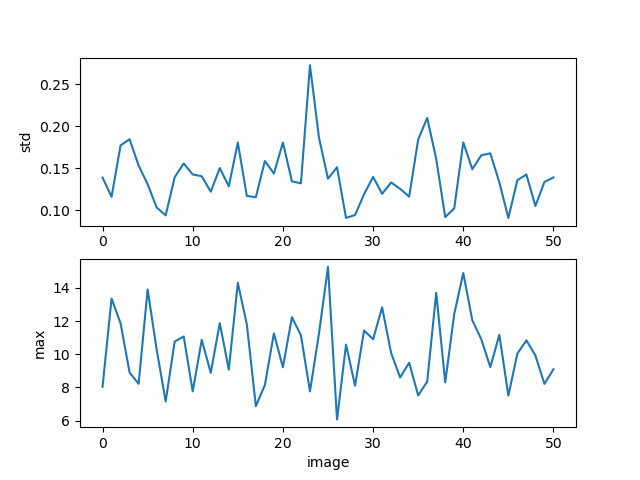

In [39]:
imageplots(stds, maxs, names)

<IPython.core.display.Javascript object>


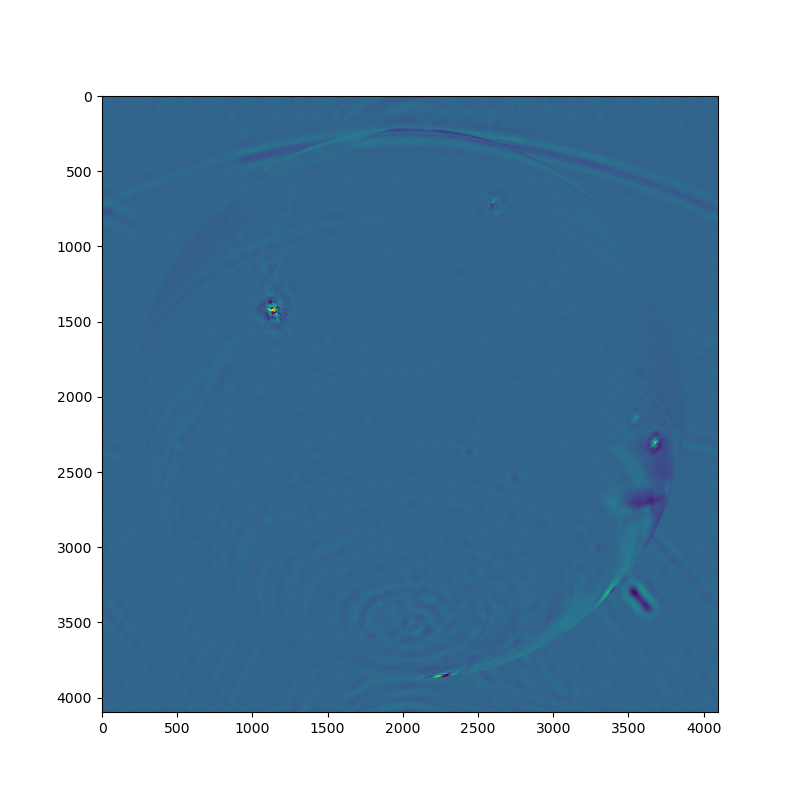

In [48]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
fmin = fd.min()
fmax = fd.max()
frange = fmax - fmin
ax1.imshow(fd.squeeze(), vmin=fmin+frange*0.25, vmax=fmax-frange*0.25)
plt.show()